In [1]:
import pandas as pd
import numpy as np

In [24]:
# Data: Close
db = pd.read_excel('Data.xlsx', index_col = "Date")

# MSD

In [83]:
db.index = pd.to_datetime(db.index)
MSD_df = db['2006':'2013']
MSD_df = (MSD_df-MSD_df.mean())/MSD_df.std() #change rolling
MSD_df = MSD_df.dropna(axis = 1) #drop nan

In [65]:
target = {}
for i in range(0,len(MSD_df.columns)-1):
    for j in range(i+1,len(MSD_df.columns)):
        tmp = ((MSD_df.iloc[:,i] - MSD_df.iloc[:,j])**2).sum()
        target[str(MSD_df.columns[i])+','+str(MSD_df.columns[j])] = tmp

In [77]:
target_df = pd.DataFrame(target, index = [0]).T
target_df.sort_values(by = 0)[0:9]


,0
"DIS,TRV",106.019533
"IBM,MCD",174.553811
"AAPL,IBM",183.653680
"CVX,KO",205.031258
"IBM,KO",225.295065
"DIS,HD",264.348677
"HD,TRV",282.786437
"PEP,PG",298.596370
"DIS,MMM",300.548727


/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


Reject Rate :  0.04797047970479705


/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



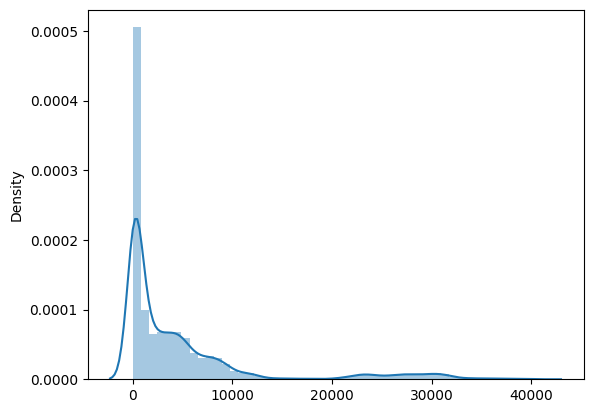

In [85]:
import random
from scipy.stats import chi
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def target_distribution(x, sigma=1):
    if x >= 0 and sigma > 0 :
        return x/(sigma**2)*np.exp(-x**2/(2*sigma**2))
    raise 'Parameter definition error ; x should >= 0 and sigma should > 0'

def proposal_distribution(df):
    return np.random.chisquare(df, 1)[0]

def proposal_calculate(target, condition):
    return chi.pdf(target, condition)

def create_markov_chain(n):
    chain = []
    chain.append(proposal_distribution(df=1))
    reject_rate = 0

    for k in range(n-1) : 
        i = chain[-1]
        j = proposal_distribution(df=i)
        u = np.random.uniform(size=1)[0]
        accepetance_rate = min(1, target_distribution(j)*proposal_calculate(i, j)/target_distribution(i)/proposal_calculate(j, i))

        if u <= accepetance_rate:
            chain.append(j)
        else:
            reject_rate += 1
            chain.append(i)
    
    reject_rate = reject_rate / (n-1)
    
    return chain, reject_rate

if __name__ == '__main__':
    chain, reject_rate = create_markov_chain(n=100000)
    print('Reject Rate : ', reject_rate)

    sns.distplot(chain)
    plt.show()

# Trade

In [3]:
df_return = db.pct_change()

In [4]:
global results

In [5]:
results = {'signals':[],
           'returns':[],
           'A_SoldPrices':[],
           'A_BoughtPrices':[],
           'B_SoldPrices':[],
           'B_BoughtPrices':[]
           }

In [6]:
# Input1 : Real return spread
# Input2 : Estimated return spread
# Output : Gain, Trading Signal

y1 = df_return.iloc[-1,0] 
y2 = df_return.iloc[-1,1]
p1 = db.iloc[-1:,0] #A Price
p2 = db.iloc[-1,1] #B Price

#First trade
i = 0

#signal
tmp0 = 0
tmp1 = 1
tmp2 = -1

#First trade
if i == 0:
    if (y1 > y2):
        signal = tmp1
        results['A_SoldPrices'].append(p1)
        results['B_BoughtPrices'].append(p2)
        i = 1
        tmp = 0
    
    elif (y1 < y2):  
        signal = tmp2
        results['A_BoughtPrices'].append(p1)
        results['B_SoldPrices'].append(p2) 
        i = 1
        tmp = 0
    else:
        signal = tmp0
        i = 0
        tmp = 1

elif i == 1:
    # After first trade
    if (y1 > y2) & (results['signals'][-1] == tmp1) :
        signal = tmp1
        results['A_SoldPrices'].append(y1)
        results['B_BoughtPrices'].append(y2)
        tmp = -np.log(results['A_SoldPrices'][-1]/results['A_BoughtPrices'][-1])+np.log(results['B_SoldPrices'][-1]/results['B_BoughtPrices'][-1])
  
    elif (y1 <y2) & (results['signals'][-1] == tmp2):  
        signal = tmp2
        results['A_BoughtPrices'].append(y1)
        results['B_SoldPrices'].append(y2)
        tmp = np.log(results['A_SoldPrices'][-1]/results['A_BoughtPrices'][-1])-np.log(results['B_SoldPrices'][-1]/results['B_BoughtPrices'][-1]) 

    else:
        signal = tmp0
        tmp = 0


results['signals'].append(signal)
results['returns'].append(tmp)